In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
%matplotlib inline

In [ ]:
data_path="/content/INR=X.csv"
df = pd.read_csv(data_path,na_values=["null"],index_col="Date",parse_dates=True,infer_datetime_format=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-27,71.320000,71.635002,71.320000,71.324997,71.324997,0
2020-01-28,71.654999,71.654999,71.178001,71.440002,71.440002,0
2020-01-29,71.230103,71.425003,71.168503,71.230400,71.230400,0
2020-01-30,71.300003,71.711998,71.300003,71.300003,71.300003,0
2020-01-31,71.639999,71.639999,71.277496,71.639999,71.639999,0


Dataframe Shape:  (262, 6)
Null Value Present:  False


<Axes: xlabel='Date'>

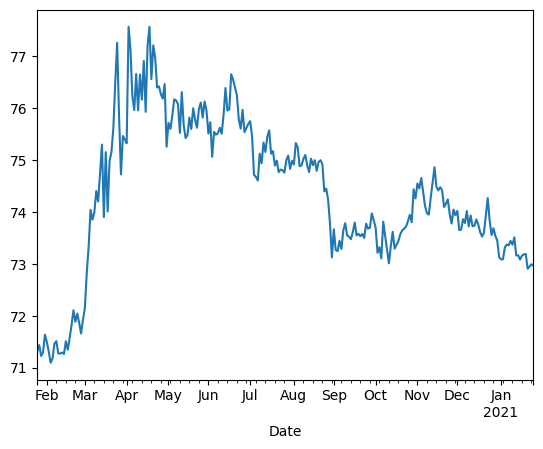

In [ ]:
print("Dataframe Shape: ", df. shape)
print("Null Value Present: ", df.isnull().values.any())
df["Adj Close"].plot()

In [ ]:
df = df['Open'].values
df = df.reshape(-1, 1)

In [ ]:
dataset_train0 = np.array(df[:int(df.shape[0]*0.8)])
dataset_test0 = np.array(df[int(df.shape[0]*0.8):])
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train0)
dataset_test = scaler.transform(dataset_test0)
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_2 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                7

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history=model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save('stock_prediction.h5')

Epoch 1/50
5/5 [==============================] - 11s 307ms/step - loss: 0.1913
Epoch 2/50
5/5 [==============================] - 1s 262ms/step - loss: 0.0494
Epoch 3/50
5/5 [==============================] - 1s 180ms/step - loss: 0.0408
Epoch 4/50
5/5 [==============================] - 1s 175ms/step - loss: 0.0248
Epoch 5/50
5/5 [==============================] - 1s 179ms/step - loss: 0.0186
Epoch 6/50
5/5 [==============================] - 1s 174ms/step - loss: 0.0157
Epoch 7/50
5/5 [==============================] - 1s 173ms/step - loss: 0.0161
Epoch 8/50
5/5 [==============================] - 1s 180ms/step - loss: 0.0146
Epoch 9/50
5/5 [==============================] - 1s 177ms/step - loss: 0.0161
Epoch 10/50
5/5 [==============================] - 1s 176ms/step - loss: 0.0127
Epoch 11/50
5/5 [==============================] - 1s 174ms/step - loss: 0.0136
Epoch 12/50
5/5 [==============================] - 1s 174ms/step - loss: 0.0109
Epoch 13/50
5/5 [==============================]

loss at epoch 1: 0.19133521616458893
loss at epoch 50: 0.007703392766416073


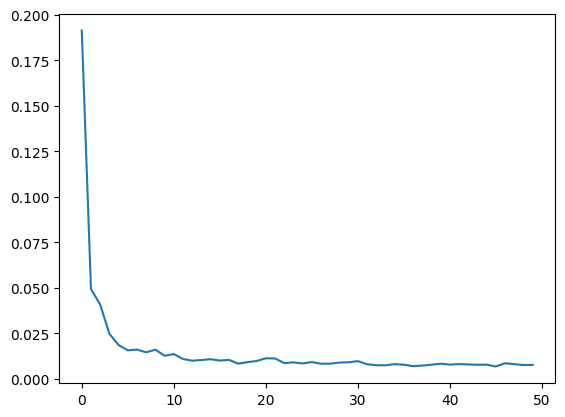

In [ ]:
print(f"loss at epoch 1: {history.history['loss'][0]}")
print(f"loss at epoch 50: {history.history['loss'][49]}")
plt.plot(history.history['loss'])

In [ ]:
model = load_model('stock_prediction.h5')

1/1 [==============================] - 2s 2s/step


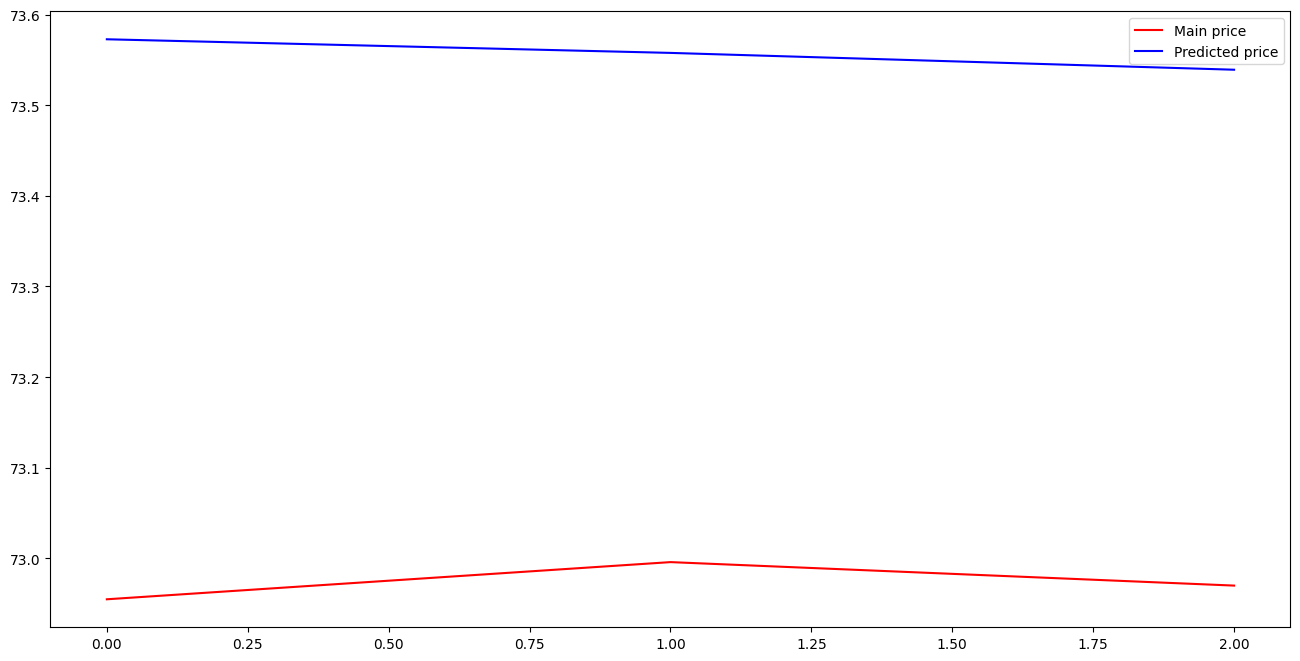

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#0000')
ax.plot(y_test_scaled, color='red', label='Main price')
plt.plot(predictions, color='blue', label='Predicted price')
plt.legend()

1/1 [==============================] - 0s 79ms/step


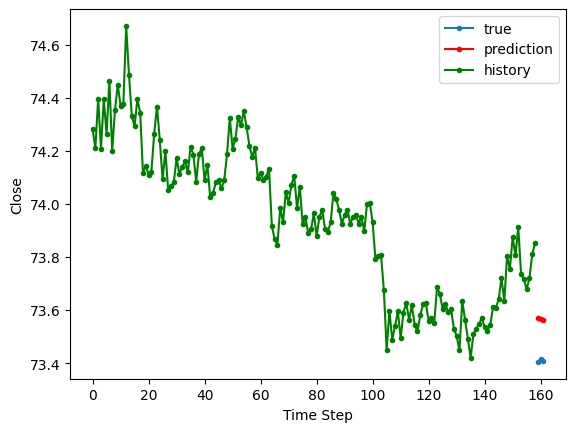

In [ ]:
y_pred = model.predict(x_test)
train_max=dataset_test0.max()
train_min=dataset_test0.min()
# Rescale the data back to the original scale
y_test = y_test*(train_max - train_min) + train_min
y_pred = y_pred*(train_max - train_min) + train_min
y_train = y_train*(train_max - train_min) + train_min

# Plotting the results
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred.flatten(), 'r', marker='.', label="prediction")
plt.plot(np.arange(0, len(y_train)), y_train.flatten(), 'g', marker='.', label="history")
plt.ylabel('Close')
plt.xlabel('Time Step')
plt.legend()
plt.show()